In [1]:
%%capture
!git clone https://github.com/matiasdperez/MEC_tesis.git

In [2]:
import os
os.chdir('MEC_tesis/')

# Hidden Switching Model


-------
_______

In [3]:
%load_ext autoreload
%autoreload 2

## 1) Setup

In [4]:
%%capture
! pip install dieboldmariano pmdarima keras-tuner tensorflow-addons

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
import tqdm as tqdm
import random
from sklearn.preprocessing import StandardScaler
from dieboldmariano import dm_test

pd.set_option('max_colwidth', 400)
warnings.filterwarnings("ignore")

np.random.seed(42)

from utils.simulators import MarkovSwitchingModel
from utils.statistical_models import *
from utils.NN_models import *

## 2) Simulación

Se instancian 2 objetos de la clase MarkovSwitchingModel y se simulan 1,000 timesteps bajo las especificaciones ya mencionadas y tomando como valor inicial 0:

In [13]:
n_steps = 1000
random_seed = 42

In [29]:
msm2 = MarkovSwitchingModel(n_steps=n_steps,
                            model_type = 'AR_1_with_intercept',
                            state_space_dim = 2,
                            transition_matrix = [[0.75, 0.25],
                                                [0.10, 0.90]],
                            intercept = [0, 1],
                            AR_1_parameter = [0.95, 0.5],
                            random_seed = random_seed
)
msm2.simulate(initial_state = 'steady_state')

msm3 = MarkovSwitchingModel(n_steps=n_steps,
                            model_type = 'all',
                            state_space_dim = 3,
                            transition_matrix = [[0.75, 0.25, 0],
                                                [0.2, 0.60, 0.2],
                                                [0, 0.2, 0.8]],
                            intercept = [0, 0.5, 1],
                            AR_1_parameter = [0.99, 0.5, 0.25],
                            variance = [0.5, 1, 2],
                            random_seed = random_seed
)
msm3.simulate(initial_state = 'random')

Steady state distribution exists and it's unique.


Simulating: 1000it [00:00, 22352.97it/s]           
Simulating: 1000it [00:00, 20567.68it/s]           


De las 1,000 observaciones simuladas, las primeras 750 constituyen el dataset de entrenamiento y las segundas 250, el de test.

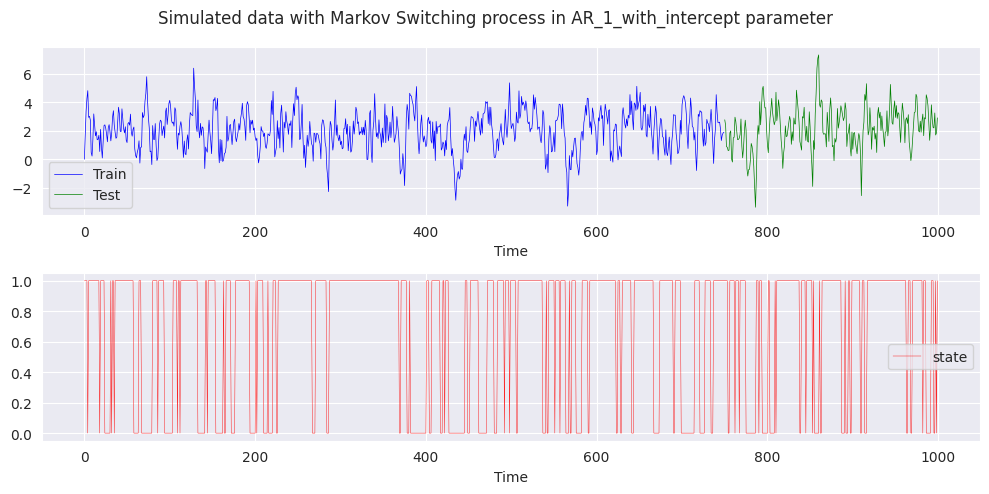

In [31]:
split_index = int(len(msm2.y) * 0.75)

msm2.plot(split_index = split_index)


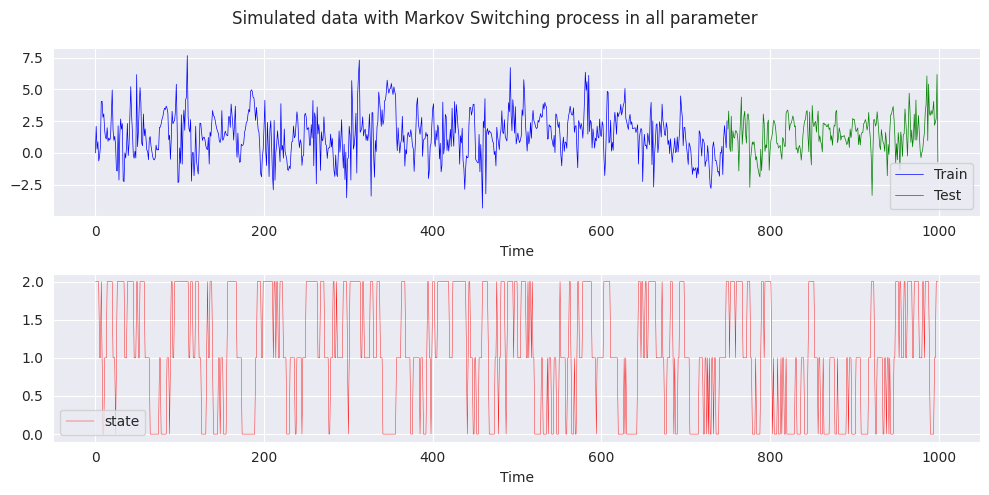

In [32]:
msm3.plot(split_index = split_index)

A continuación se presentan las funciones de autocorrelación y autocorrelación parcial para los dos modelos. En ambos casos se observa evidencia de la presencia de raíz unitaria en los procesos: un ACF empírica que decrece muy lentamente y una PACF en la que solo es estadísticamente significativo el primer lag.

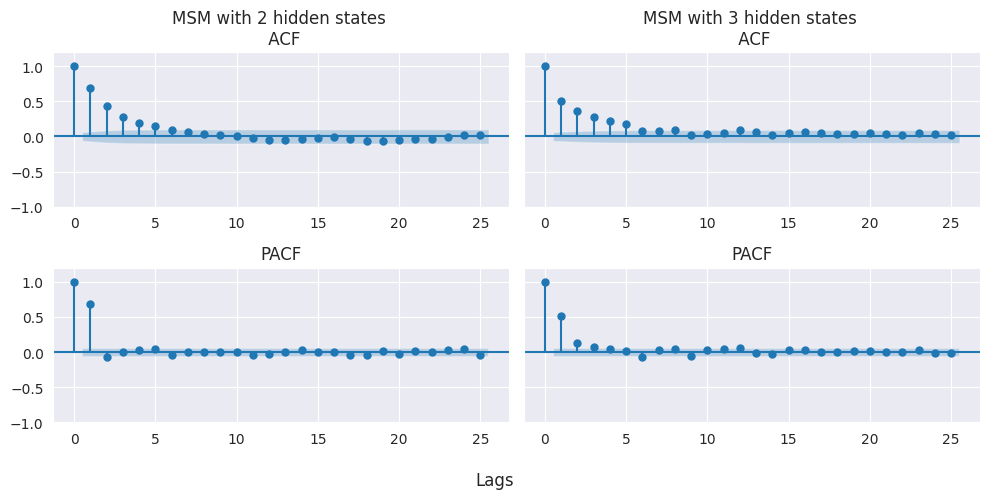

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

plot_acf(msm2.y, lags=25, ax=axs[0,0])
plot_pacf(msm2.y, lags=25, ax=axs[1,0])
axs[0,0].set_title("MSM with 2 hidden states \n ACF")
axs[0,0].set_ylim([-1, 1.2])
axs[1,0].set_title("PACF")

plot_acf(msm3.y, lags=25, ax=axs[0,1])
plot_pacf(msm3.y, lags=25, ax=axs[1,1])
axs[0,1].set_title("MSM with 3 hidden states \n ACF")
axs[0,1].set_ylim([-1, 1.2])
axs[1,1].set_title("PACF")

fig.supxlabel('Lags')
plt.tight_layout()
plt.show()

A continuación se realiza el split en train-test para cada uno de los DGP simulados. Se toman el primer 75% de las observaciones para train (750 observaciones) y el restante 25% para test (250 observaciones).

In [34]:
msm2_y_train, msm2_y_test = msm2.y[:split_index], msm2.y[split_index:]
msm3_y_train, msm3_y_test = msm3.y[:split_index], msm3.y[split_index:]

## 3) Cross-validation de hiperparámetros

En esta fase del workflow de trabajo, se utiliza el conjunto de entrenamiento y validación para buscar el set de hiperparámetros que mejor ajusta la forma funcional del modelo al problema concreto (i.e, aquel modelo que minimiza el error cuadrático medio sobre el conjunto de validación). Los espacios de hiperparámetros definidos para cada modelo son los siguientes:

1) <ins> Modelo ARIMA </ins>: se buscarán de manera automática la tupla (p,I,q), esto es, el orden del término autorregresivo AR, el orden de integración y el órden del término de medias móviles MA dentro de un espacio de hiperparámetros dado por el producto cartesiano especificado por el usuario. Por ejemplo: {0,1,2,3}x{0,1,2}x{0,1,2,3}.
A su vez, para el caso del modelo ARIMA, se utilizan 2 estrategias de cross-validation:

    * Rolling window
    * Sliding window

2) <ins> Modelo ETS </ins>: en el caso del modelo ETS, se buscarán de manera automática sobre un espacio de hiperparámetros que definen la forma funcional de las ecuaciones que rigen el modelo. El mismo se define como el producto cartesiano de los siguientes conjuntos:

    * error_type = {aditivo, multiplicativo}
    * trend_type = {sin_tendencia, aditiva, multiplicativa}
    * dampend_trend = {Verdado, Falso}
    * seasonal_component = {}

    Al igual que para el caso del modelo ARIMA, se utilizan las dos mismas estrategias de cross-validation.

3) <ins> Stacked LSTM </ins>: para el caso de las redes neuronales, se define una arquitectura general dado por el tipo de unidades o neuronas (en este caso, vanilla LSTM) y un espacio de hiperprámetros "grande", el cual no es explorado de manera exhaustiva sino que se escogen una serie de configuraciones de manera aleatoria y se recupera aquella configuración que minimiza la función de pérdida sobre el conjunto de validación (partición del conjunto de entrenamiento original). Una vez más, el espacio de hiperparámetros se construye como el cartesiano de los siguientes conjuntos:

    * Función de activación = {'relu', 'tanh', 'sigmoid', 'elu'} --> función de activación aplicadas a la cell state y al estado oculto de la red.
    * Unidades en la primera capa recurrente = {16, 32, 64, 128}
    * Incluir segunda capa LSTM = {True, False}
    * Unidades en la segunda capa recurrente (en caso de existir) = {16, 32, 64, 128}
    * Unidades en la capa densa = {16, 32, 64, 128} --> número de neuronas en la capa densa que transforma la salida vectorial de la red LSTM en el valor escalar a predecir.
    * Learning Rate = {1e-2, 1e-3, 1e-4} --> learning_rate utilizado por el optimizador en la búsqueda de los parámetros del modelo.
    * Optimizador = {'adam', 'sgd', 'rmsprop'}
    * Dropout rate = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> tasa de dropout, utilizada para eliminar conexiones entre neuronas de manera aleatoria durante la fase de entrenamientod de la red y así evitar overfitting
    * Inicializadores = {'random_normal','glorot_uniform', 'he_normal'} --> distribuciones de las que se samplean los valores iniciales de los pesos y biases de la red, y le da naturaleza estocástica al entrenamiento de la NN.
    * Coeficiente L2 = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> penalización utilizada para evitar que los pesos de la red "crezcan" demasiado y overfitteen la red (aka. weight decay).

4) <ins> LSTM con Peepholes </ins>: mismo espacio de búsqueda de hiperparámetros que el modelo *Stacked LSTM*

5) <ins> Encoder-Decoder LSTM </ins>: la única diferencia en el espacio de hiperparámetros frente a las otras arquitecturas es que en este modelo, en caso de existir una segunda capa oculta, se la fuerza a que tenga una dimensión menor al número de unidades de la primera capa oculta para lograr así la forma de "embudo" típico de las redes neuronales encoder-decoder.


### 3.1) ARIMA

In [35]:
# Definición del espacio de hiperparámetros sobre el cual buscar la mejor configuración del modelo para el problema

AR_order = [0,1,2,3]
MA_order = [0,1,2,3]
I_order = [0,1,2]

# Dado que el espacio de búsqueda de hiperparámetros tiene una cardinalidad muy alta para realizar una búsqueda exhaustiva, se opta en su lugar
# por tomar una muestra de 30 combinaciones de hiperparámetros del espacio de búsqueda.

random.seed(1234)
search_space = random.sample(list(product(AR_order, I_order, MA_order)), 30)

A modo de ejemplo, se procede a cross-validar el modelo con el search_space recien construido y bajo las siguientes especificaciones:
* `h = 1`
* `stride = 25`
* `window_length = 50`
* `evaluation_metric = mean_squared_error`

El número de folds se determina de manera automática en base a la combinación de `h`, `stride` y `window_length`.

In [36]:
msm2_vanilla = ArimaModel(msm2_y_train, msm2_y_test, **{'with_intercept':False, 'method':'nm'})

In [37]:
msm2_vanilla.cross_validate(ARIMA_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 30/30 [03:17<00:00,  6.59s/it]


A continuación se muestra el top 10 configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [38]:
msm2_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,AR_order,I_order,MA_order,rolling_median_MSE,sliding_median_MSE
16,0,2,1,0.573322,0.383395
25,2,2,1,0.776284,0.418523
26,1,2,1,0.704177,0.424307
3,0,1,1,0.693690,0.450532
19,2,2,2,0.515526,0.481761
22,1,1,0,0.665851,0.501563
15,2,1,1,0.599368,0.512636
8,1,2,2,0.473337,0.513172
24,3,2,2,0.344694,0.524941
27,1,1,1,0.722352,0.531180


In [39]:
print(f"La mejor configuración para la estrategia de sliding window es: {msm2_vanilla.best_model('sliding')}")

La mejor configuración para la estrategia de sliding window es: (0, 2, 1)


Se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,I,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [27]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

#### 3.1.1) Markov Switching Model con 2 estados

In [41]:
msm2_arima_results = defaultdict(defaultdict)
msm_best_models = defaultdict((lambda: defaultdict(dict))) #En este diccionario se guardará el mejor modelo para cada DGP y combinación de h, stride y window_length

In [42]:
%%time
for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = ArimaModel(msm2_y_train, msm2_y_test, **{'with_intercept':False, 'method':'nm'})
        model.cross_validate(ARIMA_configs=search_space,
                                                       h = h,
                                                       stride=s,
                                                       window_length=l,
                                                       eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        msm2_arima_results[h][(s, l)] = {
            'best_model': model.best_model('sliding'),
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm2'][h]['arima'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [02:43<00:00,  5.44s/it]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [02:49<00:00,  5.67s/it]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [02:58<00:00,  5.96s/it]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:48<00:00,  5.61s/it]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [02:50<00:00,  5.70s/it]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [02:58<00:00,  5.96s/it]

CPU times: user 15min 46s, sys: 12min 50s, total: 28min 36s
Wall time: 17min 10s


En la siguiente tabla, se observan los resultados de cross-validar de manera conjunta window_length y los parámetros del modelo ARIMA dado un hizonte de forecasting `h` y un `stride` de 25 timesteps. Se observa como para el caso de $h=1$, la validación automática de hiperparámetros escoge la configuración ARIMA(2,2,2) con `window_length = 25`. Para $h=7$, la configuración elegida es ARIMA(0,1,3) con `window_length = 25`.


In [43]:
msm2_arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in msm2_arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
msm2_arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,2,2,2,0.199042
1,1,25,50,0,2,1,0.383395
2,1,25,100,3,2,3,0.386163
3,7,25,25,0,1,3,1.482035
4,7,25,50,0,1,3,1.629994
5,7,25,100,0,1,3,1.513282


Se repite este mismo procedimiento para el DGP con 3 estados ocultos

#### 3.1.2) Markov Switching Model con 3 estados ocultos

In [47]:
msm3_arima_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        try:
            print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
            model = ArimaModel(msm3_y_train, msm3_y_test, **{'with_intercept':False, 'method':'nm'})
            model.cross_validate(ARIMA_configs=search_space,
                                                        h = h,
                                                        stride=s,
                                                        window_length=l,
                                                        eval_metric='mean_squared_error')
            MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
            msm3_arima_results[h][(s, l)] = {
                'best_model': model.best_model('sliding'),
                'best_MSE': MSE
            }
            if MSE < best_MSE:
                best_MSE = MSE
                msm_best_models['msm3'][h]['arima'] = model
        except:
            pass

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [02:44<00:00,  5.48s/it]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [02:48<00:00,  5.60s/it]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [02:56<00:00,  5.88s/it]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:47<00:00,  5.59s/it]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [02:48<00:00,  5.63s/it]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [03:00<00:00,  6.00s/it]


In [48]:
msm3_arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in msm3_arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
msm3_arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,0,2,1,0.287989
1,1,25,50,3,2,0,0.325257
2,1,25,100,0,1,2,0.376269
3,7,25,25,3,1,2,2.261621
4,7,25,50,2,1,2,1.975685
5,7,25,100,1,1,1,2.119220


### 3.2) ETS Model

In [49]:
# Definición del espacio de búsqueda de hiperparámetros para el modelo ETS

config = {
    'error' : ['add','mul'],
    'trend' : ['add','mul', None],
    'damped_trend' : [True, False],
    'seasonal' : [None]
}

# Dado que el espacio de búsqueda tiene baja cardinalidad, a diferencia del modelo ARIMA, se opta por una búsqueda exhaustiva de hiperparámetros

search_space = [dict(zip(config.keys(), x)) for x in product(*config.values())]

In [50]:
ets_vanilla = EtsModel(msm1_y_train, msm1_y_test)

In [51]:
ets_vanilla.cross_validate(ETS_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


A continuación se muestra el top configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [52]:
ets_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,index,rolling_median_MSE,sliding_median_MSE
2,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.69329,0.45243
0,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.69196,0.70480
1,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.69502,0.72209


In [53]:
print(f"La mejor configuración para la estrategia de sliding window es: {ets_vanilla.best_model('sliding')['index']}")

La mejor configuración para la estrategia de sliding window es: {'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}


A continuación, se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,I,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [54]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

#### 3.2.1) Markov regime-switching model con 2 estados ocultos

In [55]:
msm2_ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(msm2_y_train, msm2_y_test)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        msm2_ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['arma'][h]['ets'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  4.88it/s]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  5.83it/s]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  5.79it/s]


In [56]:
data = []

for key1, value1 in msm2_ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
msm2_ets_cv = pd.DataFrame(data, columns=columns)

msm2_ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.49473
1,1,25,50,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.45243
2,1,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.41779
3,7,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",1.11207
4,7,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.26827
5,7,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.15214


La validación cruzada de hiperparámetros arroja que para el caso del modelo ETS en el DGP con 2 estados ocultos, el `window_length` óptimo es 100 para $h=1$ y 25 para $h=7$. Para ambos horizontes de tiempo el error elegido es aditivo mientras que se incluye tendencia para $h=1$ y no para $h=7$. En ambos de los casos la cross-validation arroja que `dampened_trend = False`.

#### 3.2.3) Markov regime-switching model con 3 estados ocultos

In [59]:
msm3_ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(msm3_y_train, msm3_y_test)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        msm3_ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['arima'][h]['ets'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:03<00:00,  3.52it/s]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  4.56it/s]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:03<00:00,  3.26it/s]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


In [60]:
data = []

for key1, value1 in msm3_ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
msm3_ets_cv = pd.DataFrame(data, columns=columns)

msm3_ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.28068
1,1,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.45068
2,1,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.64502
3,7,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.21835
4,7,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",1.25049
5,7,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.05823


### 3.3) Stacked LSTM

In [61]:
# El entrenamiento de redes neuronales suele ser más estable si se normalizan los datos de entrada. Por lo tanto, se normalizan los datos de entrenamiento y test de cada DGP simulado.

scaler_msm2 = StandardScaler()

msm2_y_train_scaled = scaler_msm2.fit_transform(msm2_y_train.reshape(-1, 1))
msm2_y_test_scaled = scaler_msm2.transform(msm2_y_test.reshape(-1, 1))

In [62]:
LSTM_model = LSTMnetwork(train=msm2_y_train_scaled,
                         test=msm2_y_test_scaled,
                         seq_length=25, h=1, batch_size=64, stride=25)

In [63]:
LSTM_model.cross_validate(DGP='example_msm')

Trial 10 Complete [00h 00m 28s]
val_loss: 4.442784945170085

Best val_loss So Far: 0.8365184466044108
Total elapsed time: 00h 04m 03s


In [64]:
LSTM_model.tuner.get_best_hyperparameters()[0].values

{'activation': 'tanh',
 'recurrent_layer_1': 128,
 'recurrent_layer_2': 64,
 'dense_layer_1': 128,
 'learning_rate': 0.001,
 'optimizer': 'adam',
 'drop_out_rate': 0.1,
 'initializer': 'glorot_uniform',
 'l2_coeff': 0.0,
 'with_second_hidden_layer': True}

### 3.3.1) Markov regime-switching model con 2 estados ocultos

A diferencia de los modelos ARIMA y ETS en donde, dado `h` y fijado el `stride=25`, se *cross-validaban* conjuntamente el `window_length` y los hiperpámetros propios del modelo, en el caso de las NN se le agrega un hiperparámetro adicional: el `batch_size`, es decir, el número de secuencias que son procesadas de manera conjunta para obtener el gradiente y propagarlo hacia atrás en la red.

In [65]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [2, 5, 25, 50, 100]
batch_size = [32, 64, 128]

# Dado el costo computacional de cross-validar una red neuronal, se opta por elegir aleatoriamente 5 combinaciones de
# window_length y batch_size para cross-validar

os.chdir('notebooks/simulaciones')

random.seed(42)
search_space = product(strides_list, random.sample(list(product(window_length_list, batch_size)), 5))
search_space = [[i[0], i[1][0], i[1][1]] for i in search_space]

In [71]:
msm2_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=msm2_y_train_scaled,
                            test=msm2_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'msm1',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        msm2_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['arma'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_2_seq_7_h_64

In [72]:
flattened_data = []
for outer_key, inner_dict in msm2_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

msm2_lstm_cv = pd.DataFrame(flattened_data)

msm2_lstm_cv[['stride', 'length', 'batch_size']] = msm2_lstm_cv['config'].apply(lambda x: pd.Series(x))
msm2_lstm_cv = msm2_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in msm2_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
msm2_lstm_cv = msm2_lstm_cv.reindex(columns=column_order)

msm2_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.879078
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,1.328874
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,1.288795
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.853784
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.204451
5,7,25,50,64,elu,128,16,32,0.0010,adam,0.2,he_normal,0.0,True,0.357845
6,7,25,2,64,sigmoid,16,32,32,0.0001,sgd,0.2,glorot_uniform,0.0,False,0.667986
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.879475
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.512077
9,7,25,5,64,tanh,32,32,32,0.0001,sgd,0.0,random_normal,0.0,True,0.594591


### 3.3.2) Markov regime-switching model con 3 estados ocultos

In [70]:
scaler_msm3 = StandardScaler()

msm3_y_train_scaled = scaler_msm3.fit_transform(msm3_y_train.reshape(-1, 1))
msm3_y_test_scaled = scaler_msm3.transform(msm3_y_test.reshape(-1, 1))

In [74]:
msm3_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=msm3_y_train_scaled,
                            test=msm3_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'msm2',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        msm3_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['arima'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_2_seq_7_h_64

In [ ]:
flattened_data = []
for outer_key, inner_dict in msm3_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

msm3_lstm_cv = pd.DataFrame(flattened_data)

msm3_lstm_cv[['stride', 'length', 'batch_size']] = msm3_lstm_cv['config'].apply(lambda x: pd.Series(x))
msm3_lstm_cv = msm3_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in msm3_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
msm3_lstm_cv = msm3_lstm_cv.reindex(columns=column_order)

msm3_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.155649
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.099054
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,0.553804
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.051101
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.560577
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.162551
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.117555
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.077724
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.576359
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.075119


### 3.4) Stacked LSTM con Peepholes

#### 3.4.1) Vanilla RW

In [ ]:
arma_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=arma_y_train_scaled,
                            test=arma_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arma',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arma_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arma'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation mod

In [ ]:
flattened_data = []
for outer_key, inner_dict in arma_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arma_peephole_lstm_cv = pd.DataFrame(flattened_data)

arma_peephole_lstm_cv[['stride', 'length', 'batch_size']] = arma_peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
arma_peephole_lstm_cv = arma_peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arma_peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arma_peephole_lstm_cv = arma_peephole_lstm_cv.reindex(columns=column_order)

arma_peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.666541
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.348944
2,1,25,2,32,tanh,32,16,16,0.0001,rmsprop,0.4,random_normal,0.0,False,1.222793
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.812295
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.933156
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.617405
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.848685
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.592147
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.990898
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.728713


#### 3.4.2) ARIMA(3,1,2)

In [ ]:
arima_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=arima_y_train_scaled,
                            test=arima_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arima',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arima_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arima'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validatio

In [ ]:
flattened_data = []
for outer_key, inner_dict in arima_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arima_peephole_lstm_cv = pd.DataFrame(flattened_data)

arima_peephole_lstm_cv[['stride', 'length', 'batch_size']] = arima_peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
arima_peephole_lstm_cv = arima_peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arima_peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arima_peephole_lstm_cv = arima_peephole_lstm_cv.reindex(columns=column_order)

arima_peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.505254
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.131983
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,0.586782
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.414398
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.503100
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.916861
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.352211
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.163264
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.584967
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.202993


### 3.5) Encoder-Decoder LSTM

#### 3.5.1) ARMA(2,0,2)

In [ ]:
arma_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=arma_y_train_scaled,
                            test=arma_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arma',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arma_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arma'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner fr

In [ ]:
flattened_data = []
for outer_key, inner_dict in arma_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arma_s2s_lstm_cv = pd.DataFrame(flattened_data)

arma_s2s_lstm_cv[['stride', 'length', 'batch_size']] = arma_s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
arma_s2s_lstm_cv = arma_s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arma_s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arma_s2s_lstm_cv = arma_s2s_lstm_cv.reindex(columns=column_order)

arma_s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,sigmoid,16,0.250,0.0100,rmsprop,0.1,glorot_uniform,0.0,False,0.591428
1,1,25,2,64,sigmoid,16,0.500,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,1.077869
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,0.128660
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,0.901613
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.742322
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,1.187686
6,7,25,2,64,tanh,32,0.125,0.0001,adam,0.1,glorot_uniform,0.0,False,0.996059
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,0.874182
8,7,25,50,128,tanh,32,0.250,0.0010,rmsprop,0.2,random_normal,0.0,False,0.905686
9,7,25,5,64,relu,128,0.125,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.600798


#### 3.5.2) ARIMA(3,1,2)

In [ ]:
arima_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=arima_y_train_scaled,
                            test=arima_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arima',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arima_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arima'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tu

In [ ]:
flattened_data = []
for outer_key, inner_dict in arima_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arima_s2s_lstm_cv = pd.DataFrame(flattened_data)

arima_s2s_lstm_cv[['stride', 'length', 'batch_size']] = arima_s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
arima_s2s_lstm_cv = arima_s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arima_s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arima_s2s_lstm_cv = arima_s2s_lstm_cv.reindex(columns=column_order)

arima_s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,sigmoid,16,0.250,0.0100,rmsprop,0.1,glorot_uniform,0.0,False,0.465851
1,1,25,2,64,sigmoid,16,0.500,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.528241
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,0.056694
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,0.565266
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.264178
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,0.621669
6,7,25,2,64,sigmoid,16,0.125,0.0100,sgd,0.0,random_normal,0.0,False,0.503656
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,0.584865
8,7,25,50,128,tanh,32,0.250,0.0010,rmsprop,0.2,random_normal,0.0,False,0.272978
9,7,25,5,64,relu,128,0.125,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.332288


## 4) Entrenamiento del modelo

En este apartado, se entrena cada modelo utilizando la mejor configuración de hiperparámetros obtenida en el paso anterior. La mejor configuración es entendida como aquella que minimiza el error cuadrático medio sobre el conjunto de validación. Las especificaciones de cada modelo son las siguientes:

1) <ins> ARIMA </ins>: salvo que se indique lo contrario, el modelo bajo la mejor configuración de hiperparámetros es entrenado utilizando el algoritmo de Nelder-Mead.

2) <ins> ETS </ins>: mismo conjunto de modelos que el caso anterior. En este caso, el modelo es entrenado usando el algoritmo L-BFGS (light-memory Broyden–Fletcher–Goldfarb–Shanno), algoritmo de la familia quasi-Newton.

3) <ins> Stacked LSTM/LSTM con Peepholes/Encoder-Decoder </ins>: a diferencia de los modelos de base estadística, la estrategia de entrenamiento seguida en redes neuronales es la siguiente:
    
    a. Particionar el conjunto de entrenamiento en entrenamiento (67%) y validación (33%).
    
    b. Sobre el conjunto de entrenamiento, se formatean los datos para que se adapten a un problema supervisado: se construyen secuencias (arrays) de datos consecutivos de largo `seq_length`, las cuales constituyen el input de la red, y se intenta predecir un escalar que se encuentra a `h` timesteps (horizonte de forecast) de la última entrada del vector de input. Por ejemplo, con un `seq_length = 10` y `h=1`, se entrena a la red con secuencias de largo 10 para predecir el valor de la variable en el momento inmediato posterior.

    c. A la red se le pasa durante el forward-pass los pares (secuencia_input, escalar_output) del conjunto de entrenamiento, y durante el backpropagation, se adaptan los pesos de manera tal de minimizar la función de pérdida.
    El número de `epochs` utilizado es 100 y se utilizan 2 callbacks:

      * Reduce Learning Rate on Plateau: `patience=5` y `factor=0.1`
      * EarlyStopping: `patience=10` y `min_delta=1e-3`

    d. Se mide la performance del modelo no solo sobre el conjunto de entrenamiento sino, principalmente, sobre el conjunto de validación ya que es sobre este último donde se obtiene una idea cabal sobre cual sería la capacidad predictiva de la red en un conjunto *out-of-sample*.

Para los 5 tipos de modelos, se estima cada uno para 2 horizontes temporales `h = {1, 7}`.

In [ ]:
# Durante el proceso de cross-validation, se creo un diccionario con la mejor configuración de cada modelo para cada DGP simulado y para cada horizonte de predicción.

for key, dgp in arima_best_models.items():
    for h in dgp.values():
        for name, model in h.items():
            if name == 'arima':
                model.fit()
            elif name == 'ets':
                model.fit()
            else:
                model.fit(DGP = f'{key}')


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.0148 - mean_absolute_error: 0.7558 - val_loss: 0.4609 - val_mean_absolute_error: 0.4015 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - 0s 78ms/step - loss: 0.8549 - mean_absolute_error: 0.8077 - val_loss: 0.9158 - val_mean_absolute_error: 0.7709 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - 0s 77ms/step - loss: 1.1921 - mean_absolute_error: 0.8497 - val_loss: 0.4702 - val_mean_absolute_error: 0.6576 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - 0s 95ms/step - loss: 0.4094 - mean_absolute_error: 0.4492 - val_loss: 0.1200 - val_mean_absolute_error: 0.2490 - lr: 0.0100
Epoch 5/100
1/1 [==============================] - 0s 103ms/step - loss: 0.2037 - mean_absolute_error: 0.3743 - val_loss: 0.0556 - val_mean_absolute_error: 0.1805 - lr: 0.0100
Epoch 6/100
1/1 [==============================] - 0s 79ms/step - loss: 0.2274 - mean_absolute_error: 0.3857 - val_loss: 0.201

## 5) Forecasting

### 5.1) Escenario base - Parámetros del DGP constantes

Una vez estimado cada uno de los modelos con sus respectivas especificaciones, y para cada horizonte temporal, se procede a *forecastear* las observaciones correspondientes al conjunto de test (25% final de los datos generados). Para cada modelo se sigue la estrategia que ha de denominarse `iterativa`: en la medida que las observaciones se van realizando, se utilizan para predecir los valores futuros de la variable de interés. Así, la predicción ex-ante de $y_{t+k}$ dado $I_t$ es $\hat{y}_{t+k}$, pero una vez realizado $y_{t+k}$ en $I_{t+k}$, se utiliza este valor y no $\hat{y}_{t+k}$ para predecir $y_{t+k+h}$.

In [ ]:
for key, dgp in arima_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            print(f'Forecasting usando modelo {name}, con horizonte {key2}')
            if name in ['arima','ets']:
                model.predict(h=key2, strategy='iterative')
            else:
                model.predict(n_runs = 10, strategy = 'iterative', **{'dgp':key})

Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.72it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.53it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:27<00:00,  9.13it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:23<00:00, 10.47it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:29<00:00,  8.28it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:25<00:00,  9.50it/s]


Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:25<00:00,  9.85it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:24<00:00, 10.40it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.47it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:23<00:00, 10.27it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:23<00:00, 10.45it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:23<00:00, 10.20it/s]


### Forecasting ARMA(2,0,2)

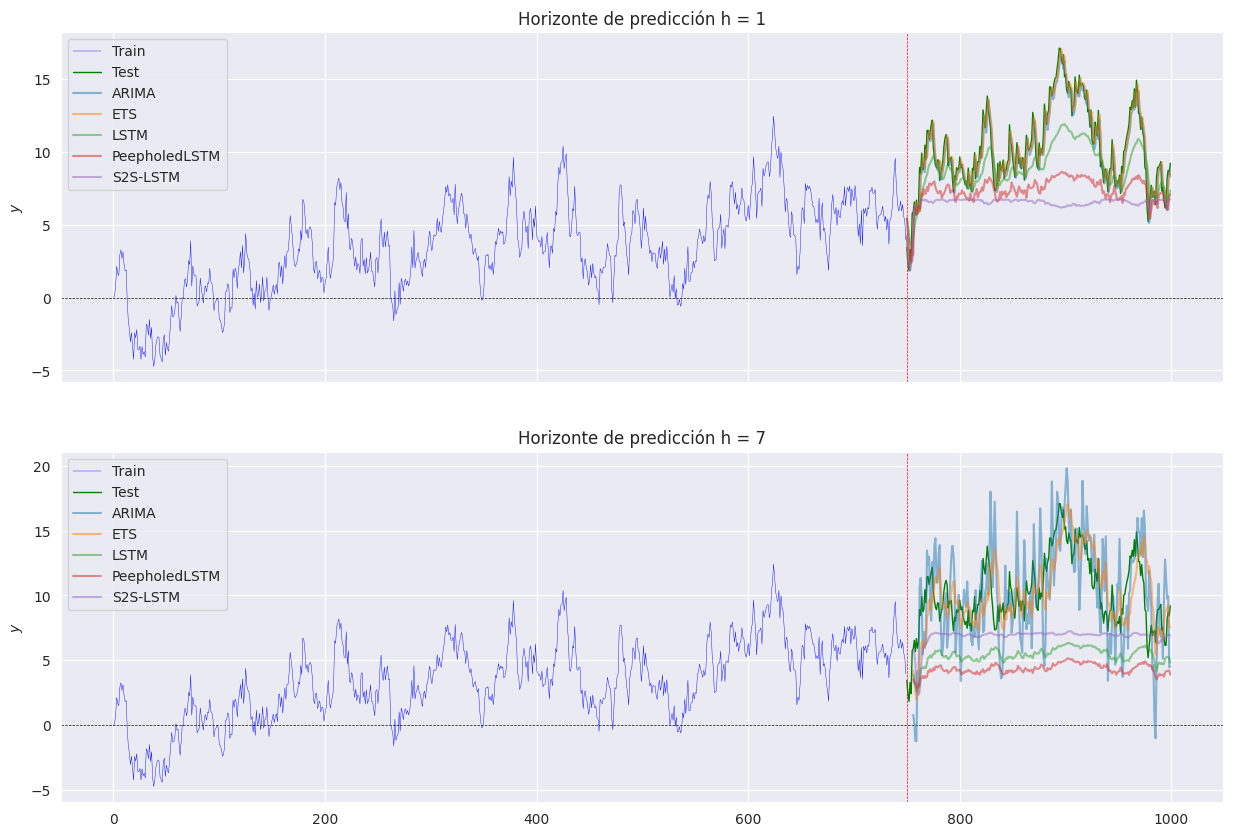

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(arma_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), arma_y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arma'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arma'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Forecasting ARIMA(3,1,2)

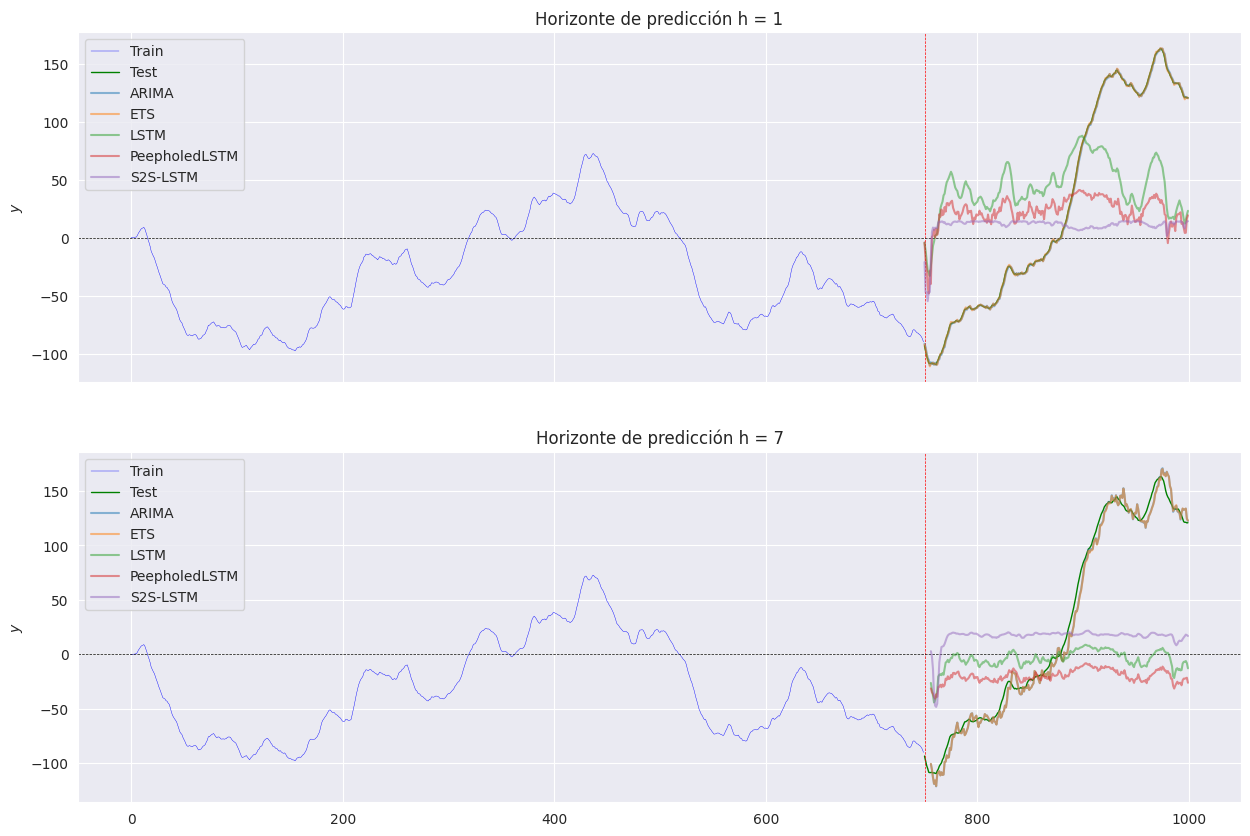

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(arima_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), arima_y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arima'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arima'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima_trend.inverse_transform(arima_best_models['arma'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima_trend.inverse_transform(arima_best_models['arma'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima_trend.inverse_transform(arima_best_models['arma'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Residuos

Se presentan adicionalmente los errores o residuos de predicción

In [ ]:
def calculate_residuals(y_true, inner_key, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions).reshape(-1)
    return y_true[inner_key-1:] - predictions

residuals = defaultdict(lambda: defaultdict(dict))

for outer_key, dgp in arima_best_models.items():
    y_true = arma_y_test if outer_key == 'arma' else arima_y_test
    scaler = scaler_arma if outer_key == 'arma' else scaler_arima_trend

    for inner_key, h in dgp.items():
        for name, model in h.items():
            residuals[outer_key][inner_key][name] = calculate_residuals(
                y_true, inner_key, model, None if name in ['arima', 'ets'] else scaler
            )

In [ ]:
import matplotlib.ticker

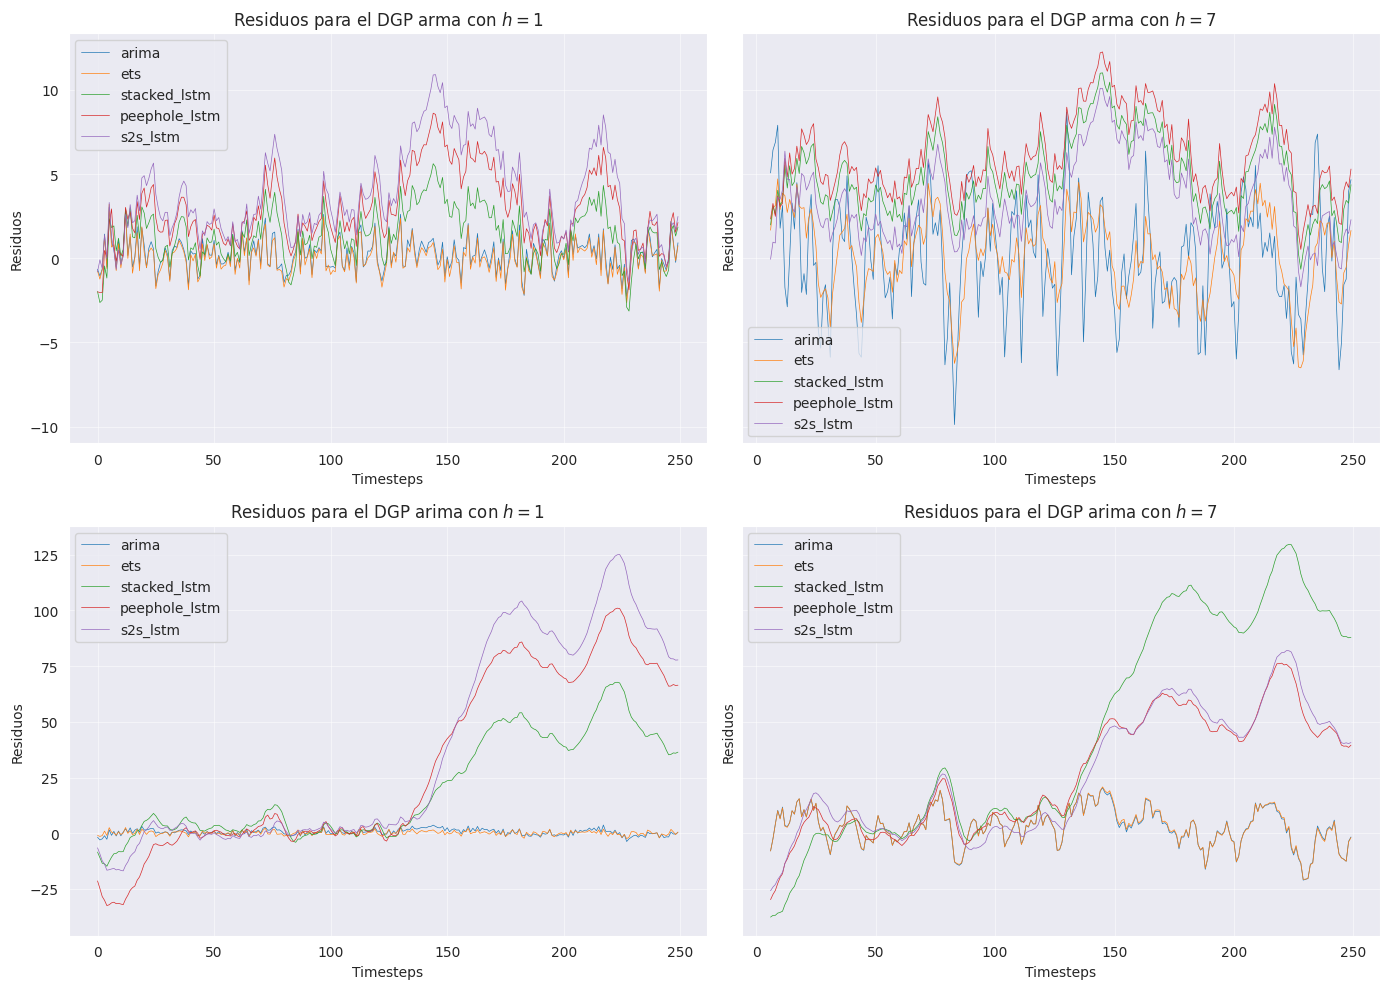

In [ ]:
def plot_residuals_grid(residuals, arma_y_test, arima_y_test):
    combinations = [(outer_key, inner_key) for outer_key, inner_dict in residuals.items() for inner_key in inner_dict.keys()]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey='row')
    axes = axes.flatten()

    for idx, (ax, (outer_key, inner_key)) in enumerate(zip(axes, combinations)):
        residuals_row = [residuals[outer_key][inner_key][name] for name in residuals[outer_key][inner_key]]

        for name, residual in residuals[outer_key][inner_key].items():
            if idx % 2 == 1:
                ax.plot(range(6, 6 + len(residual)), residual, label=f'{name}', lw=0.5)
            else:
                ax.plot(residual, label=f'{name}', lw=0.5)

        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Residuos')
        ax.set_title(f'Residuos para el DGP {outer_key} con $h={inner_key}$')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_residuals_grid(residuals, arma_y_test, arima_y_test)

### Métricas comparativas

Métricas comparativas
Para cada escenario planteado y para cada horizonte de predicción se comparan todas las versiones de los modelos (más una predicción näive en donde se forecastea $y_t$ con la última observación disponible $y_{t-1}$
) en su capacidad predictiva. En este análisis, no solo se comparan métricas como MSE o MAE directamente sino que se aplica el test de Diebold-Mariano para evaluar la significancia estadística de las diferencias entre los forecasts de cada modelo.

Primero se calculan las métricas de precisión del forecasting para una estrategia naive, en donde el mejor pronóstico es la última observación realizada de $y$
, para cualquier horizonte de pronóstico $h$
.

In [ ]:
h_list = [1,7]
scenarios = ['arma', 'arima']

ground_truth = list(zip([arma_y_train, arima_y_train],
                        [arma_y_test, arima_y_test]))

naive_forecasting = defaultdict((lambda: defaultdict(((lambda: defaultdict(dict))))))

s = 0

for i, j in ground_truth:
  for p in range(len(h_list)):
    forecast = forecast_evaluation(h=h_list[p],
                                    y_true = j,
                                    y_pred = np.r_[i[-1], j[:-h_list[p]]])

    naive_forecasting[scenarios[s]]['h_'+f'{h_list[p]}']['naive']['forecast'] = np.r_[i[-1], j[:-h_list[p]]]

  s += 1

A continuación, se le concatenan las métricas calculadas con los modelos ya entrenados:

In [ ]:
def evaluate_model(h, key2, y_true, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions)
    return forecast_evaluation(h=key2, y_true=y_true, y_pred=predictions)

def process_key(dgp, y_true, scaler=None):
    results = defaultdict(dict)
    for key2, h in dgp.items():
        for name, model in h.items():
            results['h_' + f'{key2}'][name] = evaluate_model(h, key2, y_true, model, scaler if name not in ['arima', 'ets'] else None)
    return results

comparative_results = defaultdict(lambda: defaultdict(dict))

for key, dgp in arima_best_models.items():
    if key == 'arma':
        y_true = arma_y_test
        scaler = scaler_arma
    else:
        y_true = arima_y_test
        scaler = scaler_arima_trend
    comparative_results[key] = process_key(dgp, y_true, scaler)

In [ ]:
# Inyectamos en los resultados las métricas de predicción del forecasting näive

for dgp in ['arma', 'arima']:
  for h in h_list:
    if dgp == 'arma':
      comparative_results[dgp]['h_' + f'{h}']['naive'] = forecast_evaluation(
          h=h,
          y_true=arma_y_test,
          y_pred=naive_forecasting[dgp]['h_' + f'{h}']['naive']['forecast']
      )
    else:
      comparative_results[dgp]['h_' + f'{h}']['naive'] = forecast_evaluation(
          h=h,
          y_true=arima_y_test,
          y_pred=naive_forecasting[dgp]['h_' + f'{h}']['naive']['forecast']
      )

In [ ]:
rows = []

for method, inner_dict in comparative_results.items():
    for horizon, model_dict in inner_dict.items():
        for model, metrics_dict in model_dict.items():
          for metric, value in metrics_dict.items():
              rows.append([method, horizon, model, metric, value])

df = pd.DataFrame(rows, columns=['DGP', 'horizon', 'model', 'metric', 'value'])
df = pd.pivot_table(df, index=['DGP','horizon','model'], columns='metric', values='value')

ordering_dgp = ['arma', 'arima']
ordering_horizon = ['h_1', 'h_7']
ordering_model = ['naive','arima','ets','stacked_lstm','peephole_lstm','s2s_lstm']

df_reset = df.reset_index()

df_reset['DGP'] = pd.Categorical(df_reset['DGP'], categories=ordering_dgp, ordered=True)
df_reset['horizon'] = pd.Categorical(df_reset['horizon'], categories=ordering_horizon, ordered=True)
df_reset['model'] = pd.Categorical(df_reset['model'], categories=ordering_model, ordered=True)

df_sorted = df_reset.sort_values(['DGP', 'horizon','model'])
df_sorted = df_sorted.set_index(['DGP', 'horizon', 'model'])

df_sorted

metric                            MAE       MAPE         MSE      RMSE  \
DGP   horizon model                                                      
arma  h_1     naive           0.79053    8.66722     0.98000   0.98995   
              arima           0.79000    8.57499     0.98062   0.99026   
              ets             0.78090    8.62919     0.96009   0.97984   
              stacked_lstm    1.70462   28.70754     4.44894   2.10925   
              peephole_lstm   2.95743   31.26183    12.63890   3.55512   
              s2s_lstm        3.78764   37.06499    21.19636   4.60395   
      h_7     naive           1.90045   19.93013     5.37439   2.31827   
              arima           2.63277   28.26962    10.72701   3.27521   
              ets             1.89992   19.87922     5.38427   2.32040   
              stacked_lstm    4.96672   44.72609    29.84949   5.46347   
              peephole_lstm   6.04190   55.70312    42.06495   6.48575   
              s2s_lstm        3.56099   31.29892    18.40322   4.28990   
arima h_1     naive           1.68430    5.72592     4.58434   2.14111   
              arima           1.17495    4.36755     2.10229   1.44993   
              ets             0.77461    3.10586     0.94220   0.97067   
              stacked_lstm   21.16140  296.45321   898.80535  29.98008   
              peephole_lstm  35.00438  240.76357  2456.26575  49.56073   
              s2s_lstm       39.01562  228.80547  3418.79930  58.47050   
      h_7     naive          10.53136   32.20469   177.70499  13.33060   
              arima           6.98178   26.38251    75.11857   8.66710   
              ets             7.06473   26.49415    76.65869   8.75549   
              stacked_lstm   48.39653  211.21793  4362.80421  66.05153   
              peephole_lstm  28.51789  282.55674  1363.06659  36.91973   
              s2s_lstm       28.91123  281.16157  1465.40453  38.28060   

metric                          SMAPE  
DGP   horizon model                    
arma  h_1     naive           8.72808  
              arima           8.76378  
              ets             8.64857  
              stacked_lstm   17.40174  
              peephole_lstm  31.42182  
              s2s_lstm       41.99276  
      h_7     naive          19.74394  
              arima          30.16668  
              ets            19.65776  
              stacked_lstm   60.36537  
              peephole_lstm  79.38216  
              s2s_lstm       38.80491  
arima h_1     naive           5.74914  
              arima           4.30909  
              ets             3.45881  
              stacked_lstm   27.12406  
              peephole_lstm  45.66583  
              s2s_lstm       52.90142  
      h_7     naive          26.99945  
              arima          21.43592  
              ets            21.52520  
              stacked_lstm   78.80147  
              peephole_lstm  48.60564  
              s2s_lstm       43.92051

In [ ]:
df_sorted.to_latex()

'\\begin{tabular}{lllrrrrr}\n\\toprule\n &  & metric & MAE & MAPE & MSE & RMSE & SMAPE \\\\\nDGP & horizon & model &  &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{12}{*}{arma} & \\multirow[t]{6}{*}{h_1} & naive & 0.790530 & 8.667220 & 0.980000 & 0.989950 & 8.728080 \\\\\n &  & arima & 0.790000 & 8.574990 & 0.980620 & 0.990260 & 8.763780 \\\\\n &  & ets & 0.780900 & 8.629190 & 0.960090 & 0.979840 & 8.648570 \\\\\n &  & stacked_lstm & 1.704620 & 28.707540 & 4.448940 & 2.109250 & 17.401740 \\\\\n &  & peephole_lstm & 2.957430 & 31.261830 & 12.638900 & 3.555120 & 31.421820 \\\\\n &  & s2s_lstm & 3.787640 & 37.064990 & 21.196360 & 4.603950 & 41.992760 \\\\\n\\cline{2-8}\n & \\multirow[t]{6}{*}{h_7} & naive & 1.900450 & 19.930130 & 5.374390 & 2.318270 & 19.743940 \\\\\n &  & arima & 2.632770 & 28.269620 & 10.727010 & 3.275210 & 30.166680 \\\\\n &  & ets & 1.899920 & 19.879220 & 5.384270 & 2.320400 & 19.657760 \\\\\n &  & stacked_lstm & 4.966720 & 44.726090 & 29.849490 & 5.463470 & 60.365370 \\

#### Diebold-Mariano Test

El test de Diebold-Mariano (1995) permite comparar la precisión de 2 pronósticos. En este caso, se compara la performance para cada DGP y para cada horizonte temporal $h$ del pronóstico näive frente a los demás modelos, tomando en cuenta el error cuadrático de cada serie de pronósticos.

Para ello el test de Diebold-Mariano construye la serie de las diferencias entre los errores cuadráticos de cada modelo, la llamada **loss differential series**, la cual se define como:

$\Delta^{A,B}_{k} = (e^{A}_{k})^2-(e^{B}_{k})^2$

El test de Diebold-Mariano es un test asintótico de tipo z-score sobre el promedio de dicha serie. En este caso, se aplica su versión unilateral cuyas hipótesis son las siguientes:

* $H_0$: la precisión del modelo A (en este caso, el pronóstico näive) es mayor o igual a la del modelo B (modelo alternativo).
* $H_1$: la precisión del modelo A es menor a la del modelo B.

In [ ]:
p_value_dict = defaultdict((lambda: defaultdict(dict)))

for outer_key, dgp in arima_best_models.items():
    for inner_key, h in dgp.items():
        for name, model in h.items():
          if outer_key == 'arma':
            p_value = dm_test(V = arma_y_test[inner_key-1:].reshape(-1,1),
                    P1 = arima_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1,1),
                    P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1,1),
                    one_sided = True)[1][0]
          else:
             p_value = dm_test(V = arima_y_test[inner_key-1:].reshape(-1,1),
                      P1 = arima_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1,1),
                      P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1,1),
                      one_sided = True)[1][0]

          p_value_dict[outer_key][inner_key][name] = round(p_value, 4)

In [ ]:
records = []

for key, nested_dict in p_value_dict.items():
    for h, models in nested_dict.items():
        for model_name, value in models.items():
            records.append((key, h, model_name, value))

df = pd.DataFrame(records, columns=['DGP', 'h', 'p_value', 'value'])

df_pivot = df.pivot_table(index=['DGP', 'h'], columns='p_value', values='value').sort_index(level=0, ascending=[False])

df_pivot

p_value   arima     ets  peephole_lstm  s2s_lstm  stacked_lstm
DGP   h                                                       
arma  1  0.5067  0.1484            1.0       1.0           1.0
      7  1.0000  0.5782            1.0       1.0           1.0
arima 1  0.0000  0.0000            1.0       1.0           1.0
      7  0.0000  0.0000            1.0       1.0           1.0

In [ ]:
df_pivot.to_latex()

'\\begin{tabular}{llrrrrr}\n\\toprule\n & p_value & arima & ets & peephole_lstm & s2s_lstm & stacked_lstm \\\\\nDGP & h &  &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{2}{*}{arma} & 1 & 0.506700 & 0.148400 & 1.000000 & 1.000000 & 1.000000 \\\\\n & 7 & 1.000000 & 0.578200 & 1.000000 & 1.000000 & 1.000000 \\\\\n\\cline{1-7}\n\\multirow[t]{2}{*}{arima} & 1 & 0.000000 & 0.000000 & 1.000000 & 1.000000 & 1.000000 \\\\\n & 7 & 0.000000 & 0.000000 & 1.000000 & 1.000000 & 1.000000 \\\\\n\\cline{1-7}\n\\bottomrule\n\\end{tabular}\n'

### 5.2) Escenario con *regime switching*

En esta instancia se procede a remover el conjunto de test y sustituirlo por un conjunto de datos generados por el mismo DGP pero con cambios en los parámetros que lo rigen: todos los modelos habrán sido entrenados con una muestra que difiere en su dinámica de aquella que deben forecastear, poniendo a prueba su robustez ante regime-switching. Los tipos de cambio de régimen son los que siguen:

* ARMA(2,0,2): tanto los parámetros autorregresivos como de medias móviles se incrementan en un 50%, aumentando la dependencia de $y_t$ con sus primeros rezagos (mayor inercia):
$y_t = 0.001t + 0.9y_{t-1} + 0.45y_{t-2}+ ε_{t} + 0.3ε_{t-1}+0.15ε_{t-2} \;/\; ε_{i}∼N(0,1)$

* ARIMA(3,1,2): en este caso, se simula el caso contrario en donde tanto los parámetros autorregresivos como de medias móviles se reducen a la mitad (menor inercia), sin alterar el grado de integración: $Δy_t = 0.25Δy_{t-1} + 0.1Δy_{t-2} + 0.05Δy_{t-3} + ε_t + 0.15ε_{t-1}+0.05ε_{t-2}\;/ε_i ∼ N(0,1)$



In [ ]:
arma_post_switch = cp.deepcopy(arma)
arima_post_switch = cp.deepcopy(arima)

In [ ]:
arma_post_switch.regime_switch(t_switch=split_index,
                               switch_type = 'ARIMA_parameters',
                               new_ARIMA_model = [2,0,2],
                               new_AR_params = [0.9, 0.45],
                               new_MA_params =[0.3, 0.15],
                               **{'constant':0, 'trend':0.001, 'sigma_y':1, 'initial_t':750}
                               )

arima_post_switch.regime_switch(t_switch=split_index,
                               switch_type = 'ARIMA_parameters',
                               new_ARIMA_model = [3,1,2],
                               new_AR_params = [0.25, 0.1, 0.05],
                               new_MA_params =[0.15, 0.05]
                               )


Simulating: 251it [00:00, 19327.16it/s]            
Simulating: 1000it [00:00, 23463.88it/s]           


A continuación se grafican los 2 DGP, comparando el conjunto de test original con el nuevo surgido luego del *regime-switch*.

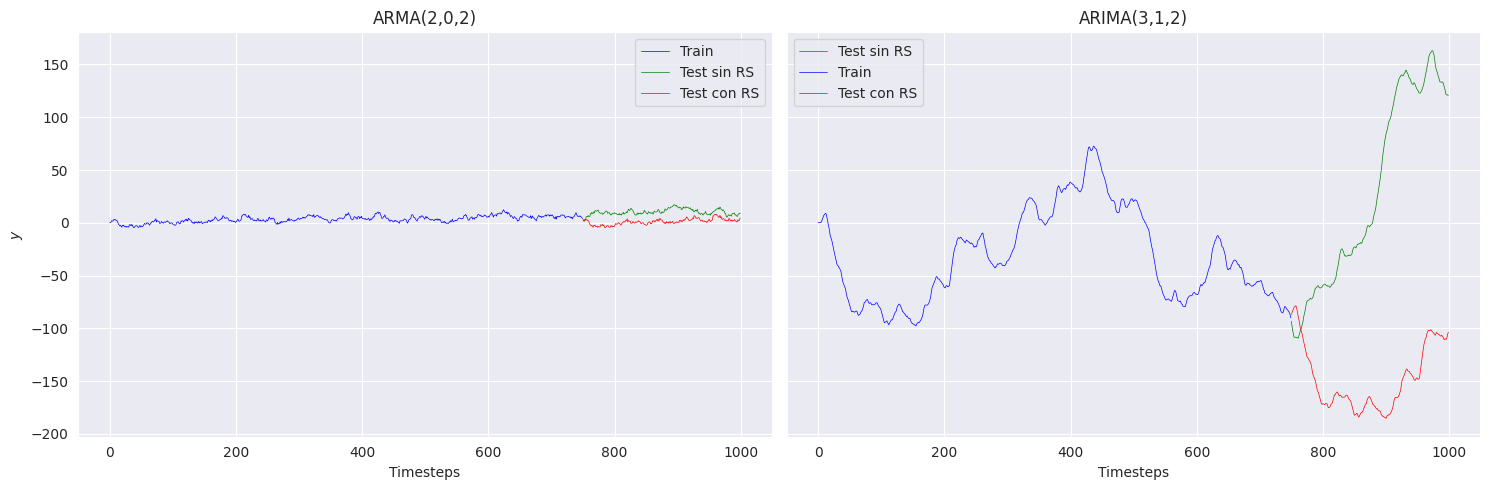

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.lineplot(x=range(split_index), y=arma.y[:split_index], ax=axs[0], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(arma.y)), y=arma.y[split_index:], ax=axs[0], lw=0.5, color='green', label='Test sin RS')
sns.lineplot(x=range(split_index, len(arma.y)), y=arma_post_switch.y[split_index:], ax=axs[0], lw=0.5, color='red', label='Test con RS')
axs[0].set_title("ARMA(2,0,2)")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("$y$")

sns.lineplot(x=range(split_index, len(arima.y)), y=arima.y[split_index:], ax=axs[1], lw=0.5, color='green', label='Test sin RS')
sns.lineplot(x=range(split_index), y=arima.y[:split_index], ax=axs[1], lw=0.5, color='blue', label='Train')
axs[1].set_title("ARIMA(3,1,2)")
sns.lineplot(x=range(split_index, len(arima.y)), y=arima_post_switch.y[split_index:], ax=axs[1], lw=0.5, color='red', label='Test con RS')
axs[1].set_xlabel("Timesteps")

plt.legend(loc='upper left')
plt.tight_layout();

La siguiente tarea es inyectar este nuevo conjunto de test en los modelos ya entrenados con el DGP anterior y forecastear utilizando la estrategia iterativa.

In [ ]:
for key, dgp in arima_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            model.forecasted = False
            if key == 'arma':
                model.test = arma_post_switch.y[split_index:]
            elif key == 'arima':
                model.test = arima_post_switch.y[split_index:]

Ahora, solo resta volver a realizar el forecasting

In [ ]:
for key, dgp in arima_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            print(f'Forecasting usando modelo {name}, con horizonte {key2}')
            if name in ['arima','ets']:
                model.predict(h=key2, strategy='iterative')
            else:
                model.predict(n_runs = 10, strategy = 'iterative', **{'dgp':'post_switch_'+key})

Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.57it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.63it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.64it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:25<00:00,  9.57it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:22<00:00, 10.99it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:24<00:00,  9.90it/s]


Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:24<00:00, 10.31it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:25<00:00,  9.79it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:24<00:00, 10.11it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:22<00:00, 10.66it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:24<00:00,  9.80it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:24<00:00,  9.95it/s]


### Forecasting ARMA(2,0,2) luego de *regime-switching*

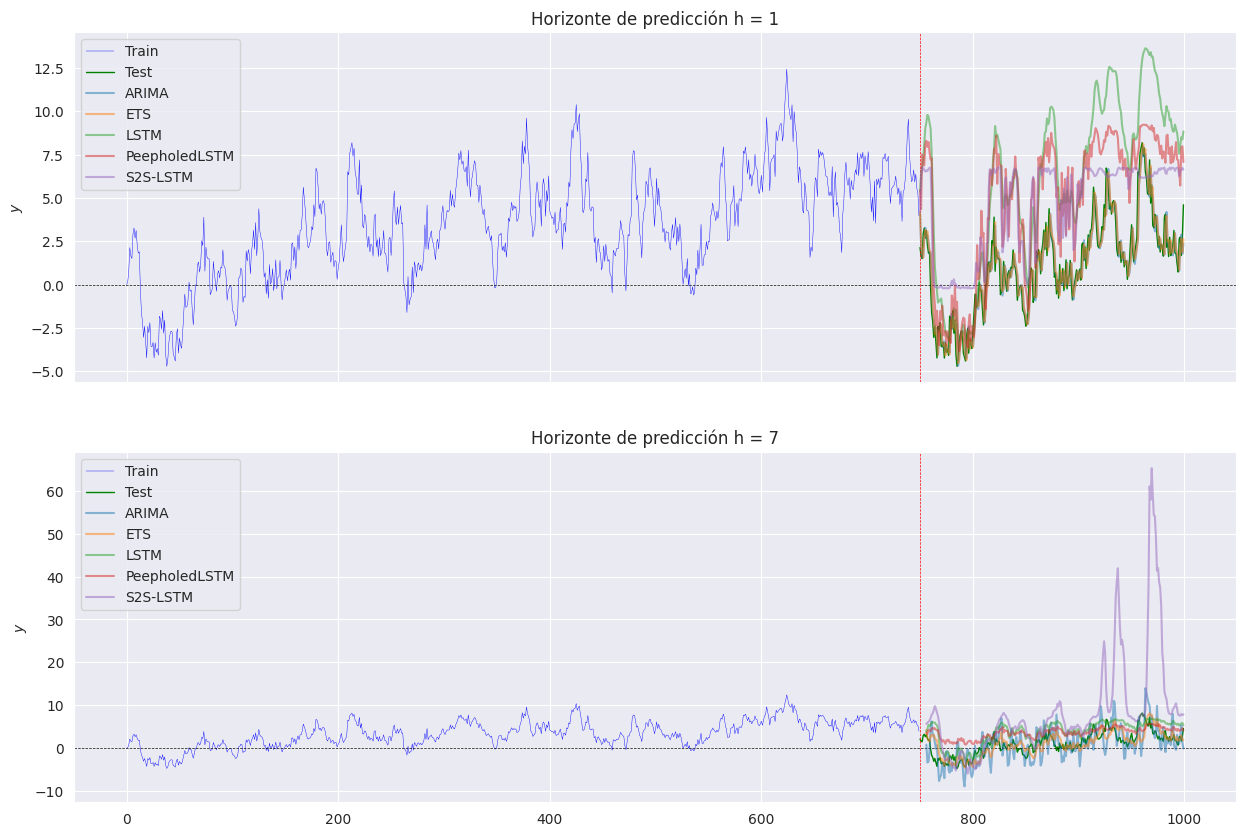

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(arma_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), arma_post_switch.y[split_index:], color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arma'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arma'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Forecasting ARIMA(3,1,2) con drift luego de *regime-switch*

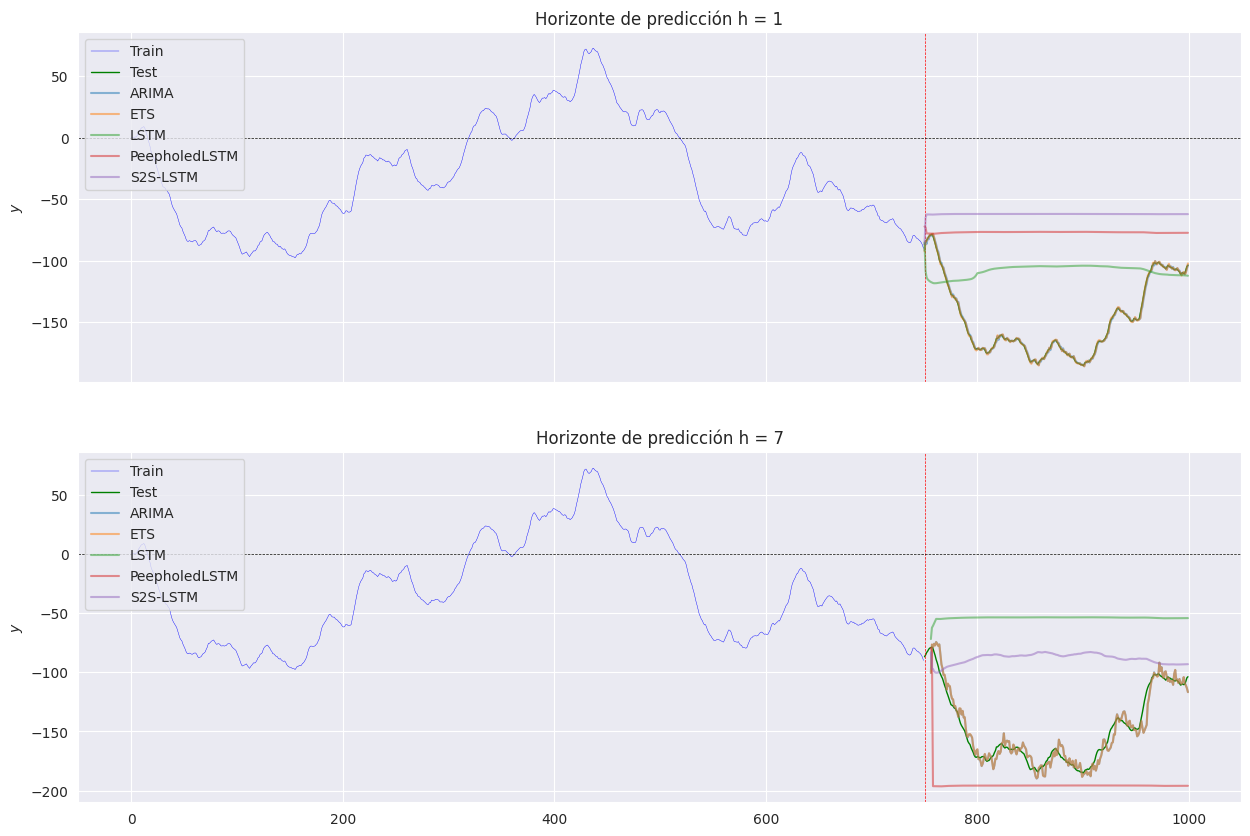

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(arima_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), arima_post_switch.y[split_index:], color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arima'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arima'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima_trend.inverse_transform(arima_best_models['arima'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima_trend.inverse_transform(arima_best_models['arima'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima_trend.inverse_transform(arima_best_models['arima'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='upper left')

    i+=1

plt.show()

#### Residuos post regime-switching

In [ ]:
residuals_post = defaultdict(lambda: defaultdict(dict))

for outer_key, dgp in arima_best_models.items():
    y_true = arma_post_switch.y[split_index:] if outer_key == 'arma' else arima_post_switch.y[split_index:]
    scaler = scaler_arma if outer_key == 'arma' else scaler_arima_trend

    for inner_key, h in dgp.items():
        for name, model in h.items():
            residuals_post[outer_key][inner_key][name] = calculate_residuals(
                y_true, inner_key, model, None if name in ['arima', 'ets'] else scaler
            )

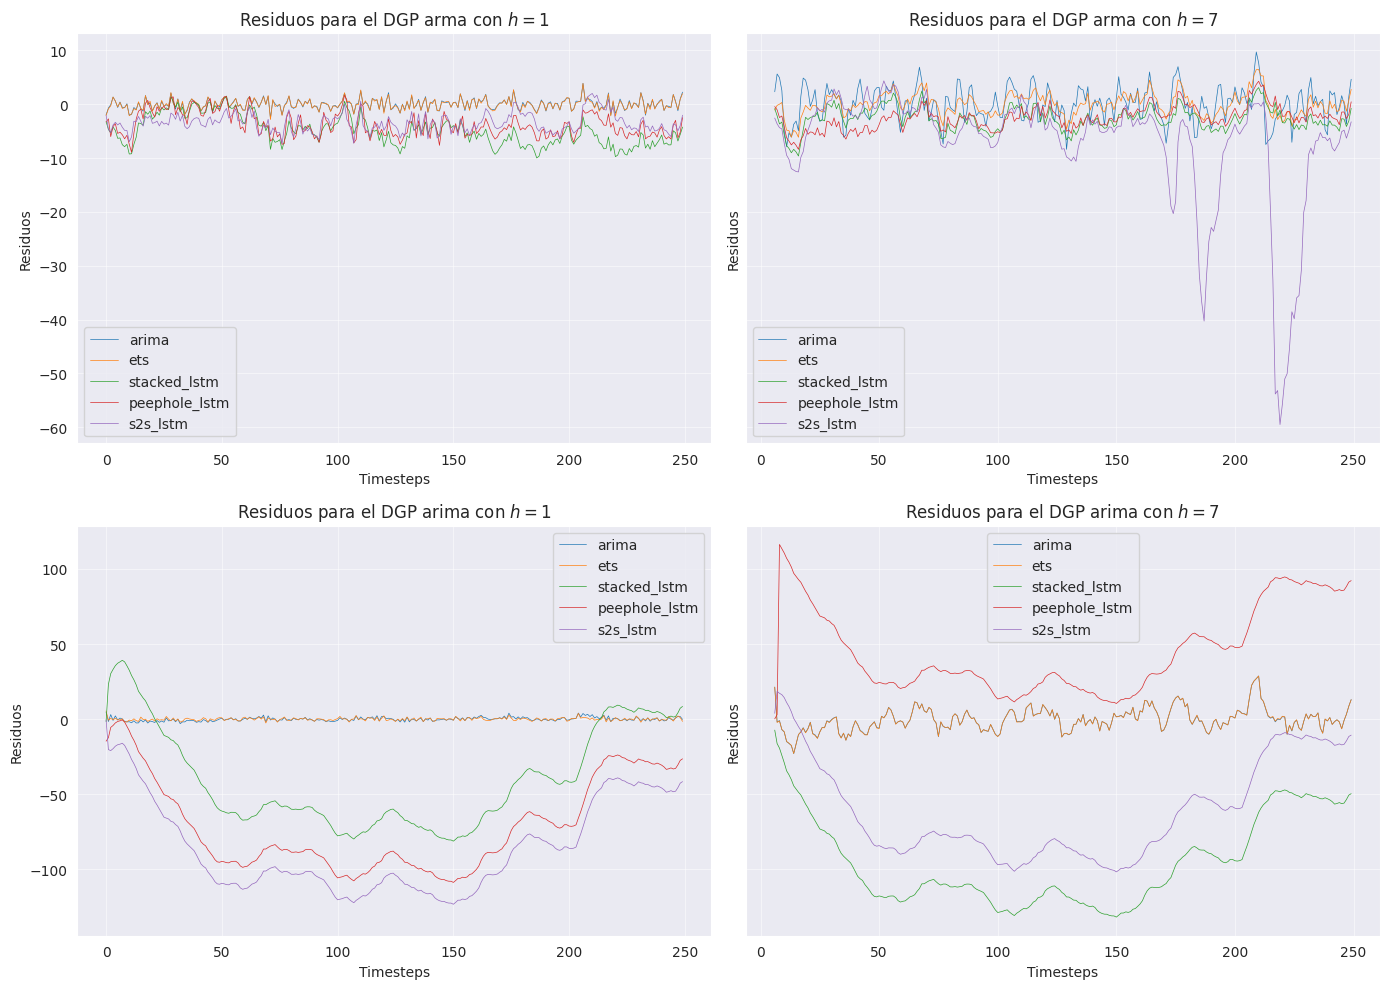

In [ ]:
plot_residuals_grid(residuals_post,
                    arma_post_switch.y[split_index:],
                    arima_post_switch.y[split_index:])


### Métricas comparativas

Se presentan nuevamente las mismas métricas de precisión del pronóstico, esta vez tras el regime-switching.

In [ ]:
h_list = [1,7]
scenarios = ['arma', 'arima']

ground_truth = list(zip([arma_post_switch.y[:split_index], arima_post_switch.y[:split_index]],
                        [arma_post_switch.y[split_index:], arima_post_switch.y[split_index:]]))

naive_forecasting = defaultdict((lambda: defaultdict(((lambda: defaultdict(dict))))))

s = 0

for i, j in ground_truth:
  for p in range(len(h_list)):
    forecast = forecast_evaluation(h=h_list[p],
                                    y_true = j,
                                    y_pred = np.r_[i[-1], j[:-h_list[p]]])

    naive_forecasting[scenarios[s]]['h_'+f'{h_list[p]}']['naive']['forecast'] = np.r_[i[-1], j[:-h_list[p]]]

  s += 1

In [ ]:
comparative_results = defaultdict(lambda: defaultdict(dict))

for key, dgp in arima_best_models.items():
    if key == 'arma':
        y_true = arma_post_switch.y[split_index:]
        scaler = scaler_arma
    else:
        y_true = arima_post_switch.y[split_index:]
        scaler = scaler_arima_trend
    comparative_results[key] = process_key(dgp, y_true, scaler)

In [ ]:
for dgp in ['arma', 'arima']:
  for h in h_list:
    if dgp == 'arma':
      comparative_results[dgp]['h_' + f'{h}']['naive'] = forecast_evaluation(
          h=h,
          y_true=arma_post_switch.y[split_index:],
          y_pred=naive_forecasting[dgp]['h_' + f'{h}']['naive']['forecast']
      )
    else:
      comparative_results[dgp]['h_' + f'{h}']['naive'] = forecast_evaluation(
          h=h,
          y_true=arima_post_switch.y[split_index:],
          y_pred=naive_forecasting[dgp]['h_' + f'{h}']['naive']['forecast']
      )

In [ ]:
rows = []

for method, inner_dict in comparative_results.items():
    for horizon, model_dict in inner_dict.items():
        for model, metrics_dict in model_dict.items():
          for metric, value in metrics_dict.items():
              rows.append([method, horizon, model, metric, value])

df_post = pd.DataFrame(rows, columns=['DGP', 'horizon', 'model', 'metric', 'value'])
df_post = pd.pivot_table(df_post, index=['DGP','horizon','model'], columns='metric', values='value')

ordering_dgp = ['arma', 'arima']
ordering_horizon = ['h_1', 'h_7']
ordering_model = ['naive','arima','ets','stacked_lstm','peephole_lstm','s2s_lstm']

df_reset_post = df_post.reset_index()

df_reset_post['DGP'] = pd.Categorical(df_reset_post['DGP'], categories=ordering_dgp, ordered=True)
df_reset_post['horizon'] = pd.Categorical(df_reset_post['horizon'], categories=ordering_horizon, ordered=True)
df_reset_post['model'] = pd.Categorical(df_reset_post['model'], categories=ordering_model, ordered=True)

df_sorted_post = df_reset_post.sort_values(['DGP', 'horizon','model'])
df_sorted_post = df_sorted_post.set_index(['DGP', 'horizon', 'model'])

df_sorted_post

metric                            MAE        MAPE         MSE      RMSE  \
DGP   horizon model                                                       
arma  h_1     naive           0.80332   136.75294     1.03887   1.01925   
              arima           0.78622   137.85207     0.97706   0.98846   
              ets             0.79091   137.71049     1.00103   1.00051   
              stacked_lstm    4.95367  1183.80615    31.29414   5.59412   
              peephole_lstm   3.88817  1003.20576    19.24650   4.38708   
              s2s_lstm        3.52601   811.65999    14.83902   3.85214   
      h_7     naive           1.63742   221.19718     4.44993   2.10949   
              arima           2.57279   335.17440    10.35647   3.21815   
              ets             1.62558   213.34555     4.40463   2.09872   
              stacked_lstm    2.94036   763.67730    11.94871   3.45669   
              peephole_lstm   2.85686   636.17760    10.92111   3.30471   
              s2s_lstm        7.83606  1717.67113   178.85595  13.37370   
arima h_1     naive           1.35707     1.00818     2.97873   1.72590   
              arima           0.99705     0.74681     1.68164   1.29678   
              ets             0.79225     0.57990     1.06789   1.03339   
              stacked_lstm   44.96552    27.15971  2683.32580  51.80083   
              peephole_lstm  70.74601    45.11549  5948.90484  77.12914   
              s2s_lstm       85.43589    55.60997  8246.42380  90.80982   
      h_7     naive           7.85273     5.73894   102.74857  10.13650   
              arima           5.71115     4.15644    57.54488   7.58583   
              ets             5.72351     4.16658    57.70464   7.59636   
              stacked_lstm   95.27805    62.15552  9963.07805  99.81522   
              peephole_lstm  45.68348    37.53351  2913.85531  53.98014   
              s2s_lstm       61.70795    38.42150  4789.48096  69.20608   

metric                           SMAPE  
DGP   horizon model                     
arma  h_1     naive           56.88349  
              arima           56.59941  
              ets             56.02702  
              stacked_lstm   117.87843  
              peephole_lstm  109.19394  
              s2s_lstm       125.06266  
      h_7     naive           90.00477  
              arima          111.53488  
              ets             88.37789  
              stacked_lstm   101.27126  
              peephole_lstm  113.95683  
              s2s_lstm       120.07665  
arima h_1     naive            1.00821  
              arima            0.74612  
              ets              0.57928  
              stacked_lstm    33.55797  
              peephole_lstm   60.15674  
              s2s_lstm        78.57605  
      h_7     naive            5.75224  
              arima            4.16258  
              ets              4.17270  
              stacked_lstm    91.25996  
              peephole_lstm   28.07687  
              s2s_lstm        49.60073

### Diebold-Mariano test

Una vez más se compara la precisión de las predicciones de cada modelo frente al pronóstico näive, post cambio de régimen.

In [ ]:
p_value_dict_post = defaultdict((lambda: defaultdict(dict)))

for outer_key, dgp in arima_best_models.items():
    for inner_key, h in dgp.items():
        for name, model in h.items():
          if outer_key == 'arma':
            p_value = dm_test(V =arma_post_switch.y[split_index:][inner_key-1:].reshape(-1,1),
                    P1 = arima_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1,1),
                    P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1,1),
                    one_sided = True)[1][0]
          else:
             p_value = dm_test(V = arima_post_switch.y[split_index:][inner_key-1:].reshape(-1,1),
                      P1 = arima_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1,1),
                      P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1,1),
                      one_sided = True)[1][0]

          p_value_dict_post[outer_key][inner_key][name] = round(p_value, 4)

In [ ]:
records = []

for key, nested_dict in p_value_dict_post.items():
    for h, models in nested_dict.items():
        for model_name, value in models.items():
            records.append((key, h, model_name, value))

df = pd.DataFrame(records, columns=['DGP', 'h', 'p_value', 'value'])

df_pivot_post = df.pivot_table(index=['DGP', 'h'], columns='p_value', values='value').sort_index(level=0, ascending=[False])

df_pivot_post

p_value  arima     ets  peephole_lstm  s2s_lstm  stacked_lstm
DGP   h                                                      
arma  1  0.023  0.0265            1.0       1.0         1.000
      7  1.000  0.1471            1.0       1.0         0.997
arima 1  0.000  0.0000            1.0       1.0         1.000
      7  0.000  0.0000            1.0       1.0         1.000